Dataset loaded for geographic analysis: (14634, 66)
PHASE 2.2: DETAILED GEOGRAPHIC ANALYSIS

2.2.1 CROSS-REGIONAL COMPARISON

REGIONAL EARLY SEXUAL DEBUT ANALYSIS
--------------------------------------------------
Region       Total    Valid    Early    Late     Prev%    95% CI         
---------------------------------------------------------------------------
Kigali City  1921     1921     879      1042     45.8     (43.5-48.0)
South        3482     3482     1512     1970     43.4     (41.8-45.1)
West         3312     3312     1540     1772     46.5     (44.8-48.2)
North        2294     2294     986      1308     43.0     (41.0-45.0)
East         3625     3625     1798     1827     49.6     (48.0-51.2)

2.2.1.1 STATISTICAL TESTING FOR REGIONAL DIFFERENCES
-------------------------------------------------------
Chi-square test of independence:
  χ² = 36.946, df = 4, p = 0.000000
  Significance: ***
  Interpretation: Significant regional differences

2.2.1.2 PAIRWISE REGIONAL COMPARISO

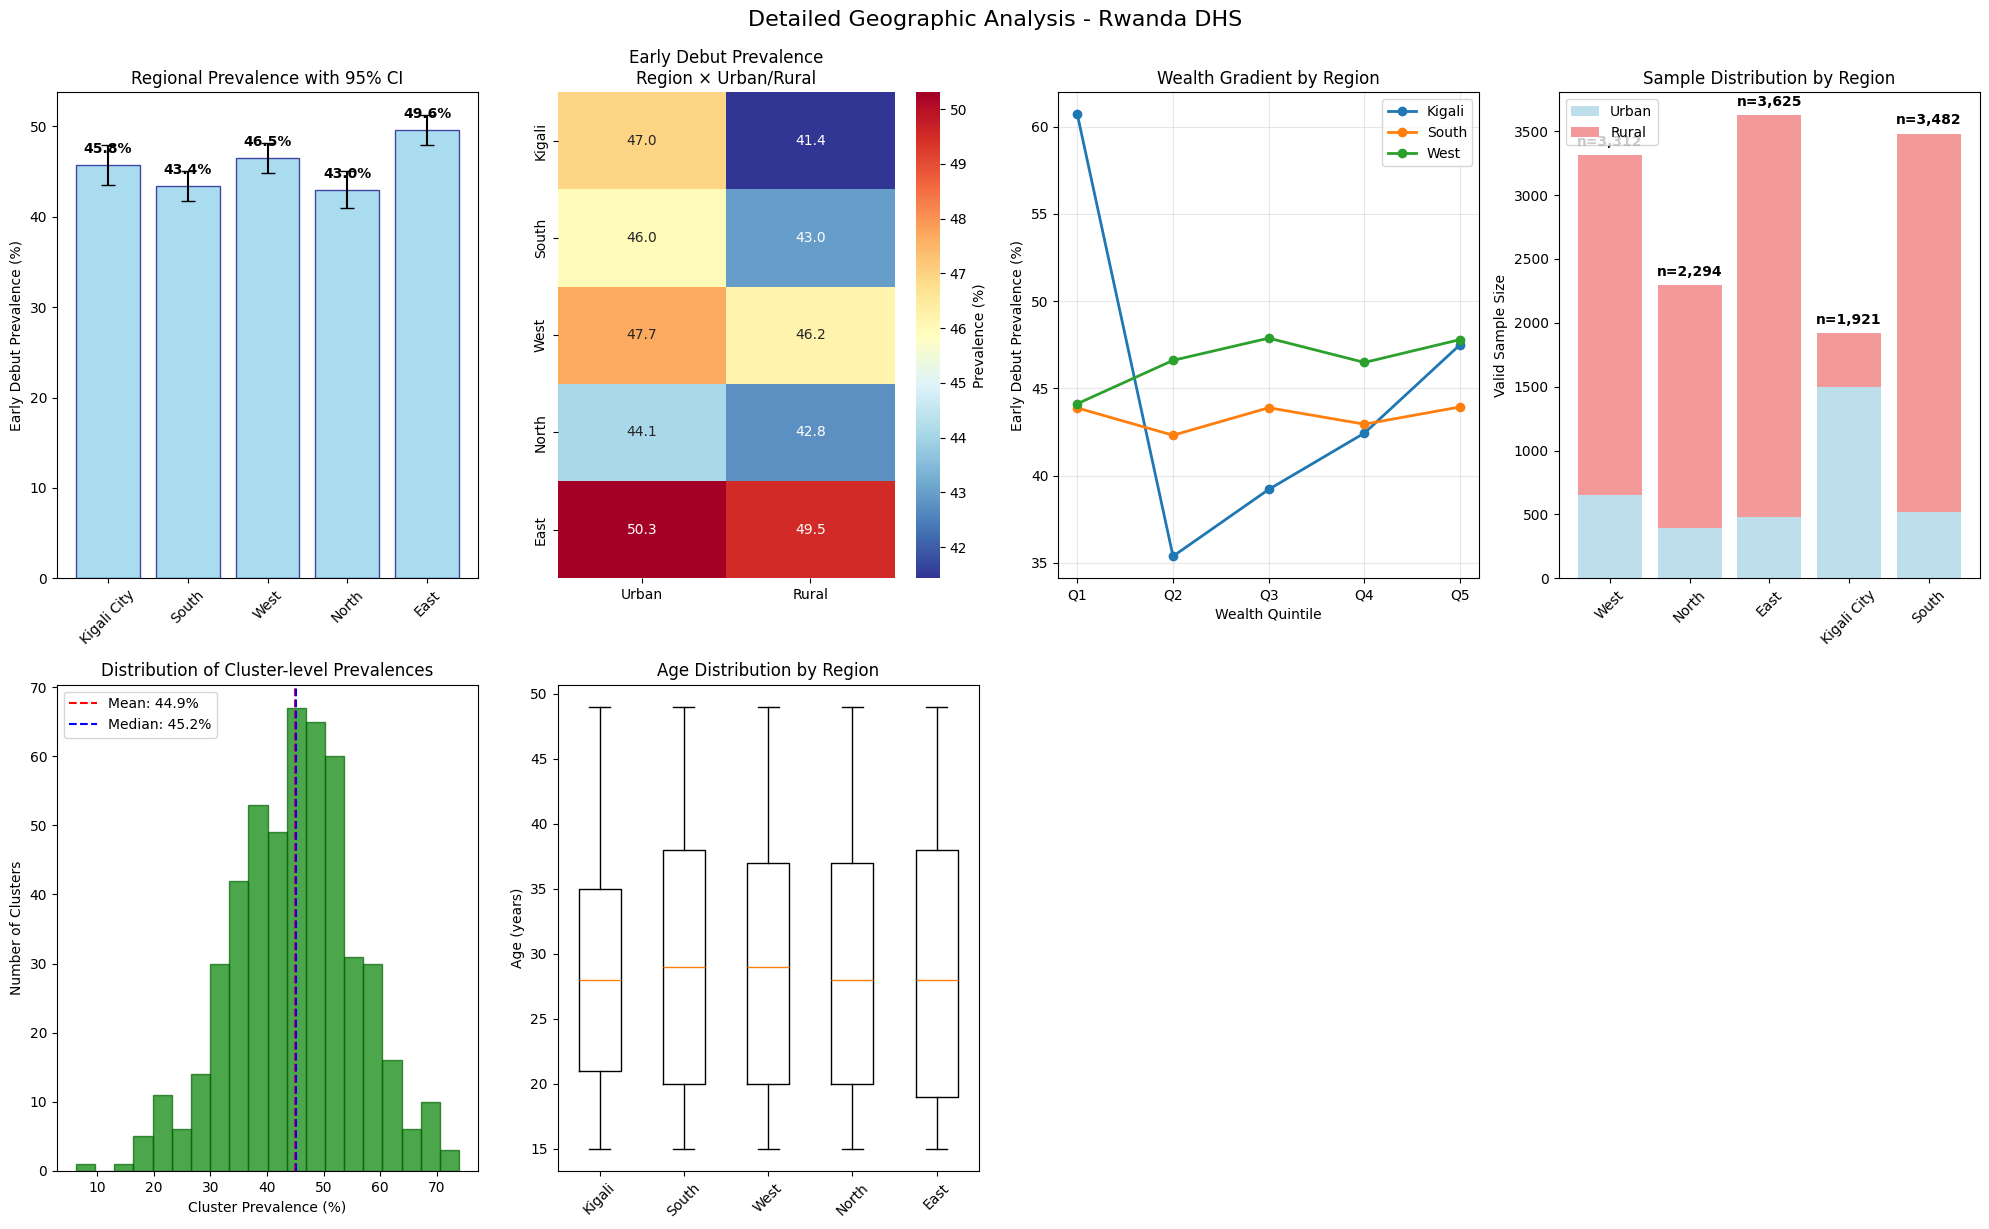


Phase 2.2 Geographic Analysis Complete!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway, kruskal
from scipy.stats import mannwhitneyu, fisher_exact
import warnings
warnings.filterwarnings('ignore')

def detailed_geographic_analysis(df):
    """
    Phase 2.2: Detailed Geographic Analysis for Rwanda DHS Dataset
    """
    
    print("="*80)
    print("PHASE 2.2: DETAILED GEOGRAPHIC ANALYSIS")
    print("="*80)
    
    # Regional and urban/rural mapping
    region_labels = {1: 'Kigali City', 2: 'South', 3: 'West', 4: 'North', 5: 'East'}
    area_labels = {1: 'Urban', 2: 'Rural'}
    
    # ================================================================
    # 2.2.1 CROSS-REGIONAL COMPARISON
    # ================================================================
    
    print("\n" + "="*60)
    print("2.2.1 CROSS-REGIONAL COMPARISON")
    print("="*60)
    
    if 'v101' in df.columns:
        
        # Regional prevalence analysis
        regional_analysis = []
        
        print("\nREGIONAL EARLY SEXUAL DEBUT ANALYSIS")
        print("-" * 50)
        print(f"{'Region':<12} {'Total':<8} {'Valid':<8} {'Early':<8} {'Late':<8} {'Prev%':<8} {'95% CI':<15}")
        print("-" * 75)
        
        regional_data = {}
        
        for region_code in sorted(df['v101'].dropna().unique()):
            region_code = int(region_code)
            region_name = region_labels.get(region_code, f'Region{region_code}')
            
            # Get subset for this region
            region_subset = df[df['v101'] == region_code]
            total_cases = len(region_subset)
            
            # Valid cases (not NaN)
            valid_subset = region_subset['early_sexual_debut'].dropna()
            valid_cases = len(valid_subset)
            
            if valid_cases > 0:
                early_cases = (valid_subset == 1.0).sum()
                late_cases = (valid_subset == 0.0).sum()
                prevalence = (early_cases / valid_cases) * 100
                
                # Calculate 95% confidence interval using Wilson method
                n = valid_cases
                p = early_cases / n
                z = 1.96  # 95% CI
                
                denominator = 1 + (z**2 / n)
                centre = (p + (z**2) / (2*n)) / denominator
                margin = z * np.sqrt((p*(1-p) + (z**2)/(4*n)) / n) / denominator
                
                ci_lower = max(0, (centre - margin) * 100)
                ci_upper = min(100, (centre + margin) * 100)
                
                regional_analysis.append({
                    'region_code': region_code,
                    'region_name': region_name,
                    'total': total_cases,
                    'valid': valid_cases,
                    'early': early_cases,
                    'late': late_cases,
                    'prevalence': prevalence,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper
                })
                
                regional_data[region_code] = valid_subset.values
                
                print(f"{region_name:<12} {total_cases:<8} {valid_cases:<8} {early_cases:<8} "
                      f"{late_cases:<8} {prevalence:<8.1f} ({ci_lower:.1f}-{ci_upper:.1f})")
        
        # Statistical test for regional differences
        if len(regional_data) > 1:
            print(f"\n2.2.1.1 STATISTICAL TESTING FOR REGIONAL DIFFERENCES")
            print("-" * 55)
            
            # Chi-square test for independence
            region_contingency = []
            region_names_test = []
            
            for region_code in sorted(regional_data.keys()):
                region_cases = regional_data[region_code]
                early = (region_cases == 1.0).sum()
                late = (region_cases == 0.0).sum()
                region_contingency.append([early, late])
                region_names_test.append(region_labels.get(region_code, f'R{region_code}'))
            
            contingency_array = np.array(region_contingency)
            
            if contingency_array.min() >= 5:  # Expected frequency requirement
                chi2, p_val, dof, expected = chi2_contingency(contingency_array)
                print(f"Chi-square test of independence:")
                print(f"  χ² = {chi2:.3f}, df = {dof}, p = {p_val:.6f}")
                
                if p_val < 0.001:
                    significance = "***"
                elif p_val < 0.01:
                    significance = "**"
                elif p_val < 0.05:
                    significance = "*"
                else:
                    significance = "ns"
                
                print(f"  Significance: {significance}")
                print(f"  Interpretation: {'Significant' if p_val < 0.05 else 'Non-significant'} regional differences")
            
            # Pairwise comparisons for significant results
            if len(regional_data) > 2 and 'p_val' in locals() and p_val < 0.05:
                print(f"\n2.2.1.2 PAIRWISE REGIONAL COMPARISONS")
                print("-" * 40)
                
                region_codes = sorted(regional_data.keys())
                pairwise_results = []
                
                for i in range(len(region_codes)):
                    for j in range(i+1, len(region_codes)):
                        region1 = region_codes[i]
                        region2 = region_codes[j]
                        
                        data1 = regional_data[region1]
                        data2 = regional_data[region2]
                        
                        # Fisher's exact test for 2x2 tables
                        early1 = (data1 == 1.0).sum()
                        late1 = (data1 == 0.0).sum()
                        early2 = (data2 == 1.0).sum()
                        late2 = (data2 == 0.0).sum()
                        
                        if min(early1, late1, early2, late2) > 0:
                            odds_ratio, p_fisher = fisher_exact([[early1, late1], [early2, late2]])
                            
                            name1 = region_labels.get(region1, f'R{region1}')
                            name2 = region_labels.get(region2, f'R{region2}')
                            
                            pairwise_results.append({
                                'comparison': f'{name1} vs {name2}',
                                'odds_ratio': odds_ratio,
                                'p_value': p_fisher
                            })
                
                # Sort by p-value and display significant comparisons
                pairwise_results.sort(key=lambda x: x['p_value'])
                
                print(f"{'Comparison':<20} {'OR':<8} {'p-value':<12} {'Significant'}")
                print("-" * 50)
                
                for result in pairwise_results:
                    sig = "Yes" if result['p_value'] < 0.05 else "No"
                    print(f"{result['comparison']:<20} {result['odds_ratio']:<8.2f} "
                          f"{result['p_value']:<12.6f} {sig}")
    
    # ================================================================
    # 2.2.2 REGION × URBAN/RURAL ANALYSIS
    # ================================================================
    
    print(f"\n" + "="*60)
    print("2.2.2 REGION × URBAN/RURAL ANALYSIS")
    print("="*60)
    
    if 'v101' in df.columns and 'v102' in df.columns:
        
        print("\nCROSS-TABULATION: REGION × URBAN/RURAL × EARLY DEBUT")
        print("-" * 55)
        
        # Create comprehensive cross-tabulation
        cross_tab_data = []
        
        print(f"{'Region':<12} {'Area':<8} {'Total':<8} {'Valid':<8} {'Early':<8} {'Prev%':<8} {'95% CI':<15}")
        print("-" * 75)
        
        region_area_combinations = []
        
        for region_code in sorted(df['v101'].dropna().unique()):
            for area_code in sorted(df['v102'].dropna().unique()):
                region_code, area_code = int(region_code), int(area_code)
                
                # Get subset
                subset = df[(df['v101'] == region_code) & (df['v102'] == area_code)]
                total_cases = len(subset)
                
                if total_cases > 0:
                    valid_cases = subset['early_sexual_debut'].dropna()
                    valid_count = len(valid_cases)
                    
                    if valid_count > 0:
                        early_count = (valid_cases == 1.0).sum()
                        prevalence = (early_count / valid_count) * 100
                        
                        # Confidence interval
                        if valid_count >= 10:  # Only calculate CI for reasonable sample sizes
                            p = early_count / valid_count
                            z = 1.96
                            margin = z * np.sqrt((p * (1-p)) / valid_count)
                            ci_lower = max(0, (p - margin) * 100)
                            ci_upper = min(100, (p + margin) * 100)
                            ci_text = f"({ci_lower:.1f}-{ci_upper:.1f})"
                        else:
                            ci_text = "(CI: small n)"
                        
                        region_name = region_labels.get(region_code, f'R{region_code}')
                        area_name = area_labels.get(area_code, f'A{area_code}')
                        
                        cross_tab_data.append({
                            'region': region_name,
                            'area': area_name,
                            'region_code': region_code,
                            'area_code': area_code,
                            'total': total_cases,
                            'valid': valid_count,
                            'early': early_count,
                            'prevalence': prevalence
                        })
                        
                        region_area_combinations.append((region_code, area_code, valid_cases.values))
                        
                        print(f"{region_name:<12} {area_name:<8} {total_cases:<8} {valid_count:<8} "
                              f"{early_count:<8} {prevalence:<8.1f} {ci_text:<15}")
        
        # Statistical analysis of region × area interaction
        if len(cross_tab_data) >= 4:  # Need sufficient cells
            print(f"\n2.2.2.1 INTERACTION ANALYSIS: REGION × URBAN/RURAL")
            print("-" * 50)
            
            # Create 2-way contingency table for log-linear analysis
            region_area_contingency = pd.crosstab(
                [df['v101'], df['v102']], 
                df['early_sexual_debut'], 
                dropna=True
            )
            
            print("Region × Area Contingency Table:")
            print(region_area_contingency)
            
            # Test for interaction effect using three-way analysis
            # Compare urban vs rural within each region
            regional_urban_rural_diff = []
            
            for region_code in sorted(df['v101'].dropna().unique()):
                region_code = int(region_code)
                region_data = df[df['v101'] == region_code]
                
                urban_data = region_data[region_data['v102'] == 1]['early_sexual_debut'].dropna()
                rural_data = region_data[region_data['v102'] == 2]['early_sexual_debut'].dropna()
                
                if len(urban_data) > 5 and len(rural_data) > 5:
                    urban_prev = (urban_data == 1.0).mean() * 100
                    rural_prev = (rural_data == 1.0).mean() * 100
                    difference = urban_prev - rural_prev
                    
                    # Statistical test
                    urban_early = (urban_data == 1.0).sum()
                    urban_total = len(urban_data)
                    rural_early = (rural_data == 1.0).sum()
                    rural_total = len(rural_data)
                    
                    if min(urban_early, urban_total-urban_early, rural_early, rural_total-rural_early) > 0:
                        odds_ratio, p_value = fisher_exact([
                            [urban_early, urban_total-urban_early],
                            [rural_early, rural_total-rural_early]
                        ])
                        
                        regional_urban_rural_diff.append({
                            'region': region_labels.get(region_code, f'R{region_code}'),
                            'urban_prev': urban_prev,
                            'rural_prev': rural_prev,
                            'difference': difference,
                            'p_value': p_value
                        })
            
            if regional_urban_rural_diff:
                print(f"\nUrban-Rural Differences by Region:")
                print(f"{'Region':<12} {'Urban%':<8} {'Rural%':<8} {'Diff':<8} {'p-value':<12}")
                print("-" * 50)
                
                for result in regional_urban_rural_diff:
                    print(f"{result['region']:<12} {result['urban_prev']:<8.1f} "
                          f"{result['rural_prev']:<8.1f} {result['difference']:<8.1f} "
                          f"{result['p_value']:<12.6f}")
    
    # ================================================================
    # 2.2.3 SOCIOECONOMIC GRADIENTS BY GEOGRAPHY
    # ================================================================
    
    print(f"\n" + "="*60)
    print("2.2.3 SOCIOECONOMIC GRADIENTS BY GEOGRAPHY")
    print("="*60)
    
    if 'v190' in df.columns and 'v101' in df.columns:  # Wealth quintile and region
        
        print("\n2.2.3.1 WEALTH GRADIENTS BY REGION")
        print("-" * 40)
        
        wealth_labels = {1: 'Poorest', 2: 'Poorer', 3: 'Middle', 4: 'Richer', 5: 'Richest'}
        
        # Create wealth × region analysis
        wealth_region_matrix = []
        
        print(f"{'Region':<12} {'Poorest':<8} {'Poorer':<8} {'Middle':<8} {'Richer':<8} {'Richest':<8} {'Gradient'}")
        print("-" * 75)
        
        regional_gradients = {}
        
        for region_code in sorted(df['v101'].dropna().unique()):
            region_code = int(region_code)
            region_name = region_labels.get(region_code, f'R{region_code}')
            region_data = df[df['v101'] == region_code]
            
            wealth_prevalences = []
            wealth_counts = []
            
            for wealth_quintile in range(1, 6):
                wealth_subset = region_data[region_data['v190'] == wealth_quintile]['early_sexual_debut'].dropna()
                
                if len(wealth_subset) > 0:
                    prevalence = (wealth_subset == 1.0).mean() * 100
                    wealth_prevalences.append(prevalence)
                    wealth_counts.append(len(wealth_subset))
                else:
                    wealth_prevalences.append(np.nan)
                    wealth_counts.append(0)
            
            # Calculate gradient (correlation between wealth quintile and prevalence)
            valid_gradients = [(i+1, prev) for i, prev in enumerate(wealth_prevalences) if not np.isnan(prev)]
            
            if len(valid_gradients) >= 3:
                wealth_levels, prevalences = zip(*valid_gradients)
                gradient_corr = np.corrcoef(wealth_levels, prevalences)[0, 1]
                regional_gradients[region_code] = gradient_corr
            else:
                gradient_corr = np.nan
            
            # Display row
            prev_strings = [f"{prev:.1f}" if not np.isnan(prev) else "--" for prev in wealth_prevalences]
            gradient_str = f"{gradient_corr:.3f}" if not np.isnan(gradient_corr) else "--"
            
            print(f"{region_name:<12} {prev_strings[0]:<8} {prev_strings[1]:<8} "
                  f"{prev_strings[2]:<8} {prev_strings[3]:<8} {prev_strings[4]:<8} {gradient_str}")
        
        # Overall gradient analysis
        print(f"\n2.2.3.2 OVERALL SOCIOECONOMIC PATTERNS")
        print("-" * 40)
        
        # Test for linear trend across wealth quintiles (overall)
        overall_wealth_trend = []
        for wealth_quintile in range(1, 6):
            wealth_subset = df[df['v190'] == wealth_quintile]['early_sexual_debut'].dropna()
            if len(wealth_subset) > 0:
                prevalence = (wealth_subset == 1.0).mean() * 100
                overall_wealth_trend.append(prevalence)
        
        if len(overall_wealth_trend) == 5:
            wealth_quintiles = list(range(1, 6))
            overall_gradient = np.corrcoef(wealth_quintiles, overall_wealth_trend)[0, 1]
            print(f"Overall wealth gradient (correlation): {overall_gradient:.3f}")
            
            # Linear regression for trend test
            from scipy import stats
            slope, intercept, r_value, p_value, std_err = stats.linregress(wealth_quintiles, overall_wealth_trend)
            print(f"Linear trend: slope = {slope:.2f}, R² = {r_value**2:.3f}, p = {p_value:.6f}")
            
            trend_direction = "Decreasing" if slope < 0 else "Increasing" if slope > 0 else "Flat"
            significance = "significant" if p_value < 0.05 else "non-significant"
            print(f"Interpretation: {trend_direction} trend ({significance})")
    
    # ================================================================
    # 2.2.4 GEOGRAPHIC CLUSTERING ANALYSIS
    # ================================================================
    
    print(f"\n" + "="*60)
    print("2.2.4 GEOGRAPHIC CLUSTERING ANALYSIS")
    print("="*60)
    
    if 'v001' in df.columns:  # Cluster information
        
        print("\n2.2.4.1 CLUSTER-LEVEL ANALYSIS")
        print("-" * 35)
        
        cluster_analysis = df.groupby('v001')['early_sexual_debut'].agg([
            'count',
            lambda x: x.dropna().count(),  # valid cases
            lambda x: (x == 1.0).sum(),    # early cases
            lambda x: (x == 1.0).mean() * 100 if x.dropna().count() > 0 else np.nan  # prevalence
        ]).rename(columns={'count': 'total', '<lambda_0>': 'valid', '<lambda_1>': 'early', '<lambda_2>': 'prevalence'})
        
        # Remove clusters with insufficient data
        cluster_analysis = cluster_analysis[cluster_analysis['valid'] >= 5]
        
        if len(cluster_analysis) > 0:
            print(f"Cluster-level statistics (n={len(cluster_analysis)} clusters with ≥5 valid cases):")
            print(f"  Mean cluster prevalence: {cluster_analysis['prevalence'].mean():.1f}%")
            print(f"  Median cluster prevalence: {cluster_analysis['prevalence'].median():.1f}%")
            print(f"  Range: {cluster_analysis['prevalence'].min():.1f}% - {cluster_analysis['prevalence'].max():.1f}%")
            print(f"  Standard deviation: {cluster_analysis['prevalence'].std():.1f}%")
            
            # Identify extreme clusters
            q25, q75 = cluster_analysis['prevalence'].quantile([0.25, 0.75])
            iqr = q75 - q25
            low_threshold = q25 - 1.5 * iqr
            high_threshold = q75 + 1.5 * iqr
            
            low_outliers = cluster_analysis[cluster_analysis['prevalence'] < low_threshold]
            high_outliers = cluster_analysis[cluster_analysis['prevalence'] > high_threshold]
            
            print(f"\n  Outlier clusters:")
            print(f"    Low prevalence outliers: {len(low_outliers)} clusters")
            if len(low_outliers) > 0:
                print(f"      Range: {low_outliers['prevalence'].min():.1f}% - {low_outliers['prevalence'].max():.1f}%")
            
            print(f"    High prevalence outliers: {len(high_outliers)} clusters")
            if len(high_outliers) > 0:
                print(f"      Range: {high_outliers['prevalence'].min():.1f}% - {high_outliers['prevalence'].max():.1f}%")
            
            # Intracluster correlation coefficient (ICC) estimation
            # This measures how similar individuals within the same cluster are
            print(f"\n2.2.4.2 CLUSTER EFFECT ESTIMATION")
            print("-" * 35)
            
            total_variance = df['early_sexual_debut'].dropna().var()
            
            # Between-cluster variance
            cluster_means = cluster_analysis['prevalence'] / 100  # Convert to proportion
            between_variance = cluster_means.var()
            
            # Rough ICC estimation (simplified)
            if total_variance > 0:
                icc_estimate = between_variance / total_variance
                print(f"  Estimated ICC (design effect indicator): {icc_estimate:.4f}")
                
                if icc_estimate > 0.05:
                    print(f"  Interpretation: Substantial clustering effect (ICC > 0.05)")
                    print(f"  Recommendation: Account for clustering in statistical models")
                elif icc_estimate > 0.01:
                    print(f"  Interpretation: Moderate clustering effect")
                else:
                    print(f"  Interpretation: Minimal clustering effect")
    
    return {
        'regional_analysis': regional_analysis if 'regional_analysis' in locals() else None,
        'cross_tab_data': cross_tab_data if 'cross_tab_data' in locals() else None,
        'regional_gradients': regional_gradients if 'regional_gradients' in locals() else None,
        'cluster_analysis': cluster_analysis if 'cluster_analysis' in locals() else None
    }

def create_geographic_visualizations(df, geographic_results):
    """
    Create detailed geographic visualizations
    """
    
    fig = plt.figure(figsize=(20, 12))
    
    region_labels = {1: 'Kigali', 2: 'South', 3: 'West', 4: 'North', 5: 'East'}
    
    # 1. Regional prevalence with confidence intervals
    plt.subplot(2, 4, 1)
    if geographic_results['regional_analysis']:
        regional_data = geographic_results['regional_analysis']
        regions = [d['region_name'] for d in regional_data]
        prevalences = [d['prevalence'] for d in regional_data]
        ci_lowers = [d['ci_lower'] for d in regional_data]
        ci_uppers = [d['ci_upper'] for d in regional_data]
        
        x_pos = range(len(regions))
        bars = plt.bar(x_pos, prevalences, yerr=[np.array(prevalences) - np.array(ci_lowers),
                                                 np.array(ci_uppers) - np.array(prevalences)],
                      capsize=5, color='skyblue', edgecolor='navy', alpha=0.7)
        
        plt.xticks(x_pos, regions, rotation=45)
        plt.ylabel('Early Debut Prevalence (%)')
        plt.title('Regional Prevalence with 95% CI')
        
        # Add value labels
        for bar, prev in zip(bars, prevalences):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                    f'{prev:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 2. Region × Urban/Rural heatmap
    plt.subplot(2, 4, 2)
    if 'v101' in df.columns and 'v102' in df.columns:
        pivot_data = []
        region_names = []
        area_names = ['Urban', 'Rural']
        
        for region_code in sorted(df['v101'].dropna().unique()):
            region_code = int(region_code)
            region_name = region_labels.get(region_code, f'R{region_code}')
            region_names.append(region_name)
            
            row_data = []
            for area_code in [1, 2]:  # Urban, Rural
                subset = df[(df['v101'] == region_code) & (df['v102'] == area_code)]['early_sexual_debut'].dropna()
                if len(subset) > 0:
                    prevalence = (subset == 1.0).mean() * 100
                    row_data.append(prevalence)
                else:
                    row_data.append(np.nan)
            pivot_data.append(row_data)
        
        if pivot_data:
            heatmap_data = pd.DataFrame(pivot_data, index=region_names, columns=area_names)
            sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                       cbar_kws={'label': 'Prevalence (%)'})
            plt.title('Early Debut Prevalence\nRegion × Urban/Rural')
    
    # 3. Wealth gradient by region
    plt.subplot(2, 4, 3)
    if 'v190' in df.columns and 'v101' in df.columns:
        wealth_labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
        
        for region_code in sorted(df['v101'].dropna().unique())[:3]:  # Show top 3 regions
            region_code = int(region_code)
            region_name = region_labels.get(region_code, f'R{region_code}')
            
            wealth_prevalences = []
            for wealth_quintile in range(1, 6):
                subset = df[(df['v101'] == region_code) & (df['v190'] == wealth_quintile)]['early_sexual_debut'].dropna()
                if len(subset) > 0:
                    prevalence = (subset == 1.0).mean() * 100
                    wealth_prevalences.append(prevalence)
                else:
                    wealth_prevalences.append(np.nan)
            
            valid_data = [(i, prev) for i, prev in enumerate(wealth_prevalences) if not np.isnan(prev)]
            if len(valid_data) >= 3:
                x_vals, y_vals = zip(*valid_data)
                plt.plot(x_vals, y_vals, marker='o', label=region_name, linewidth=2)
        
        plt.xticks(range(5), wealth_labels)
        plt.xlabel('Wealth Quintile')
        plt.ylabel('Early Debut Prevalence (%)')
        plt.title('Wealth Gradient by Region')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 4. Sample sizes by region and area
    plt.subplot(2, 4, 4)
    if geographic_results['cross_tab_data']:
        cross_data = geographic_results['cross_tab_data']
        
        # Create stacked bar chart
        regions_unique = list(set([d['region'] for d in cross_data]))
        urban_counts = []
        rural_counts = []
        
        for region in regions_unique:
            urban_count = sum([d['valid'] for d in cross_data if d['region'] == region and d['area'] == 'Urban'])
            rural_count = sum([d['valid'] for d in cross_data if d['region'] == region and d['area'] == 'Rural'])
            urban_counts.append(urban_count)
            rural_counts.append(rural_count)
        
        x_pos = range(len(regions_unique))
        plt.bar(x_pos, urban_counts, label='Urban', color='lightblue', alpha=0.8)
        plt.bar(x_pos, rural_counts, bottom=urban_counts, label='Rural', color='lightcoral', alpha=0.8)
        
        plt.xticks(x_pos, regions_unique, rotation=45)
        plt.ylabel('Valid Sample Size')
        plt.title('Sample Distribution by Region')
        plt.legend()
        
        # Add total labels
        totals = [u + r for u, r in zip(urban_counts, rural_counts)]
        for i, total in enumerate(totals):
            plt.text(i, total + 50, f'n={total:,}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Cluster-level prevalence distribution
    plt.subplot(2, 4, 5)
    if geographic_results['cluster_analysis'] is not None:
        cluster_data = geographic_results['cluster_analysis']
        prevalences = cluster_data['prevalence'].dropna()
        
        if len(prevalences) > 0:
            plt.hist(prevalences, bins=20, alpha=0.7, color='green', edgecolor='darkgreen')
            plt.axvline(prevalences.mean(), color='red', linestyle='--', 
                       label=f'Mean: {prevalences.mean():.1f}%')
            plt.axvline(prevalences.median(), color='blue', linestyle='--', 
                       label=f'Median: {prevalences.median():.1f}%')
            
            plt.xlabel('Cluster Prevalence (%)')
            plt.ylabel('Number of Clusters')
            plt.title('Distribution of Cluster-level Prevalences')
            plt.legend()
    
    # 6-8. Regional comparison plots
    if len(df['v101'].dropna().unique()) >= 5:
        region_codes = sorted(df['v101'].dropna().unique())[:5]
        
        for i, region_code in enumerate(region_codes):
            plt.subplot(2, 4, 6)  # Just use one subplot for combined regional comparison
            if i == 0:  # Only create the plot once
                
                # Age distribution by region
                age_data_by_region = []
                region_labels_plot = []
                
                for rc in region_codes:
                    rc = int(rc)
                    region_subset = df[df['v101'] == rc]['v012'].dropna()
                    if len(region_subset) > 0:
                        age_data_by_region.append(region_subset.values)
                        region_labels_plot.append(region_labels.get(rc, f'R{rc}'))
                
                if age_data_by_region:
                    plt.boxplot(age_data_by_region, labels=region_labels_plot)
                    plt.xticks(rotation=45)
                    plt.ylabel('Age (years)')
                    plt.title('Age Distribution by Region')
    
    plt.tight_layout()
    plt.suptitle('Detailed Geographic Analysis - Rwanda DHS', fontsize=16, y=1.02)
    plt.show()

# Execute the geographic analysis
if __name__ == "__main__":
    dataset_path = r"C:\Users\USER\Desktop\MUKABUGINGO_THESIS_CODES\ANALYSIS\rwanda_dhs_processed.csv"
    
    try:
        df = pd.read_csv(dataset_path)
        print(f"Dataset loaded for geographic analysis: {df.shape}")
        
        # Run detailed geographic analysis
        geographic_results = detailed_geographic_analysis(df)
        
        # Create visualizations
        print("\nGenerating geographic visualizations...")
        create_geographic_visualizations(df, geographic_results)
        
        print("\nPhase 2.2 Geographic Analysis Complete!")
        
    except FileNotFoundError:
        print("Dataset not found. Please ensure preprocessing completed successfully.")
    except Exception as e:
         print(f"Error in geographic analysis: {e}")